# Sine Wave Regression with MAML and Reptile

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V

import pandas as pd
import random
import seaborn as sbs
from tqdm import tqdm_notebook as tqdm
sbs.set_style("darkgrid")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Link: https://github.com/AdrienLE/ANIML

This notebook reproduces both [MAML](https://arxiv.org/abs/1703.03400) and the similar [Reptile](https://arxiv.org/abs/1803.02999).

The goal of both of these papers is to solve the K-shot learning problem. In K-shot learning, we need to train a neural network to generalize based on a very small number of examples (often on the order of 10 or so) instead of the often thousands of examples we see in datasets like ImageNet.

However, in preparation for K-shot learning, you are allowed to train on many similar K-shot problems to learn the best way to generalize based on only K examples.

This is **learning to learn** or **meta-learning**.

The meta-learning approach of both Reptile and MAML is to come up with an **initialization** for neural networks that is easily generalizable to similar tasks. This is different to “Learning to Learn by Gradient Descent by Gradient Descent” in which we weren’t learning an initialization but rather an optimizer.

## Transfer Learning

This approach is very similar to **transfer learning**, in which we train a network on, say, ImageNet, and it later turns out that fine-tuning this network makes it easy to learn another image dataset, with much less data. Indeed, transfer learning can be seen as a form of metalearning. Indeed, it can be used to learn from very small datasets as you can see [here](https://towardsdatascience.com/fun-with-small-image-data-sets-8c83d95d0159).

The difference here is that the initial network was trained with the explicit purpose of being easily generalizable, whereas transfer learning just “accidentally” happens to work, and thus might not work optimally.

Indeed, it is fairly easy to find a in which transfer learnings fails to learn a good initialization. For this we need to look at the 1D sine wave regression problem.

## Sine Wave Regression

In this K-shot problem, each **task** consists in learning a modified sine function. Specifically, for each task, the underlying function will be of the form $y = a \sin(x + b)$, with both $a$ and $b$ chosen randomly, and the **goal** of our neural network is to learn to find $y$ given $x$ based on only 10 $(x, y)$ pairs.

Let's write our sine wave task and plot a couple of examples:

In [2]:
class SineWaveTask:
    
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)

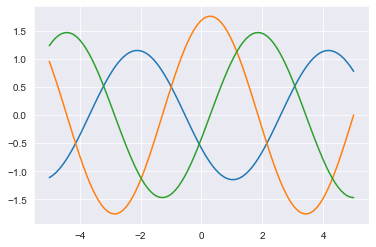

In [3]:
SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()
plt.show()

To understand why this is going to be a problem for transfer learning, let's plot 1,000 of them:

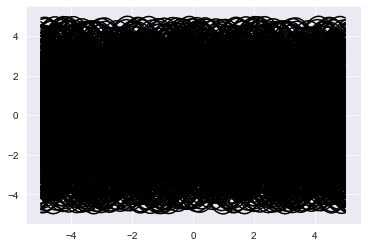

In [4]:
for _ in range(1000):
    SineWaveTask().plot(color="black")

Looks like there is a lot of overlap at each x value, to say the least...

Since there are multiple possible values for each x across multiple tasks, if we train a single neural net to deal with multiple tasks at the same time, its best bet will simply be to return the average y value across all tasks for each x. What does that look like?

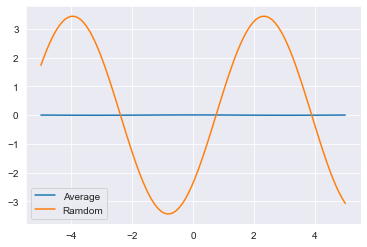

In [5]:
all_x, all_y = [], []

for _ in range(10000):
    curx, cury = SineWaveTask().test_set(size=100)
    all_x.append(curx.numpy())
    all_y.append(cury.numpy())
    
avg, = plt.plot(all_x[0], np.mean(all_y, axis=0))
rand, = SineWaveTask().plot()
plt.legend([avg, rand], ["Average", "Ramdom"])
plt.show()

The average is basically 0, which means a neural network trained on a lot of tasks would simply return 0 everywhere! It is unclear that this will actually help very much, and yet this is the transfer learning approach in this case...

Let's see how well it does by actually implementing the model:

In [6]:
TRAIN_SIZE = 10000
TEST_SIZE = 1000

class ModifiableModule(nn.Module):
    def params(self):
        return [p for _, p in self.named_params()]
    
    def named_leaves(self):
        return []
    
    def named_submodules(self):
        return []
    
    def named_params(self):
        subparams = []
        for name, mod in self.named_submodules():
            for subname, param in mod.named_params():
                subparams.append((name + '.' + subname, param))
        return self.named_leaves() + subparams
    
    def set_param(self, name, param):
        if '.' in name:
            n = name.split('.')
            module_name = n[0]
            rest = '.'.join(n[1:])
            for name, mod in self.named_submodules():
                if module_name == name:
                    mod.set_param(rest, param)
                    break
        else:
            setattr(self, name, param)
            
    def copy(self, other, same_var=False):
        for name, param in other.named_params():
            if not same_var:
                param = V(param.data.clone(), requires_grad=True)
            self.set_param(name, param)

In [7]:
class GradLinear(ModifiableModule):
    
    def __init__(self, *args, **kwargs):
        super().__init__()
        ignore = nn.Linear(*args, **kwargs)
        self.weights = V(ignore.weight.data, requires_grad=True)
        self.bias = V(ignore.bias.data, requires_grad=True)
        
    def forward(self, x):
        return F.linear(x, self.weights, self.bias)
    
    def named_leaves(self):
        return [('weights', self.weights), ('bias', self.bias)]

In [8]:
class SineModel(ModifiableModule):
    
    def __init__(self):
        super().__init__()
        self.hidden1 = GradLinear(1, 40)
        self.hidden2 = GradLinear(40, 40)
        self.out = GradLinear(40, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.out(x)
    
    def named_submodules(self):
        return [('hidden1', self.hidden1), ('hidden2', self.hidden2), ('out', self.out)]

In [9]:
SINE_TRAIN = [SineWaveTask() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask() for _ in range(TEST_SIZE)]

ONE_SIDED_EXAMPLE = None
while ONE_SIDED_EXAMPLE is None:
    cur = SineWaveTask()
    x, _ = cur.training_set()
    x = x.numpy()
    if np.max(x) < 0 or np.min(x) > 0:
        ONE_SIDED_EXAMPLE = cur

SINE_TRANSFER = SineModel()

In [10]:
def sine_fit1(net, wave, optim=None, get_test_loss=False, create_graph=False, force_new=False):
    net.train()
    if optim is not None:
        optim.zero_grad()
    x, y = wave.training_set(force_new=force_new)
    loss = F.mse_loss(net(V(x[:, None])), V(y).unsqueeze(1))
    loss.backward(create_graph=create_graph, retain_graph=True)
    if optim is not None:
        optim.step()
    if get_test_loss:
        net.eval()
        x, y = wave.test_set()
        loss_test = F.mse_loss(net(V(x[:, None])), V(y))
        return loss.data.cpu().numpy()[0], loss_test.data.cpu().numpy()[0]
    return loss.data.cpu().numpy() #[0]

def fit_transfer(epochs=1):
    optim = torch.optim.Adam(SINE_TRANSFER.params())

    for _ in range(epochs):
        for t in random.sample(SINE_TRAIN, len(SINE_TRAIN)):
            sine_fit1(SINE_TRANSFER, t, optim)
            
fit_transfer()

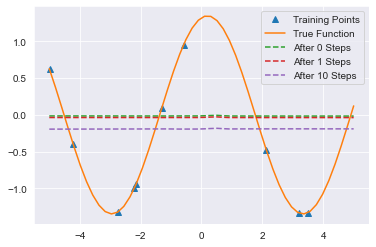

In [11]:
def copy_sine_model(model):
    m = SineModel()
    m.copy(model)
    return m

def eval_sine_test(model, test, fits=(0, 1), lr=0.01):
    xtest, ytest = test.test_set()
    xtrain, ytrain = test.training_set()

    model = copy_sine_model(model)
    # Not sure if this should be Adam or SGD.
    optim = torch.optim.SGD(model.params(), lr)
        
    def get_loss(res):
        return F.mse_loss(res, V(ytest[:, None])).cpu().data.numpy()#[0]
    
    fit_res = []
    if 0 in fits:
        results = model(V(xtest[:, None]))
        fit_res.append((0, results, get_loss(results)))
    for i in range(np.max(fits)):
        sine_fit1(model, test, optim)
        if i + 1 in fits:
            results = model(V(xtest[:, None]))
            fit_res.append(
                (
                    i + 1, 
                    results,
                    get_loss(results)
                )
            )

    return fit_res

def plot_sine_test(model, test, fits=(0, 1), lr=0.01):
    xtest, ytest = test.test_set()
    xtrain, ytrain = test.training_set()

    fit_res = eval_sine_test(model, test, fits, lr)
    
    train, = plt.plot(xtrain.numpy(), ytrain.numpy(), '^')
    ground_truth, = plt.plot(xtest.numpy(), ytest.numpy())
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(xtest.numpy(), res.cpu().data.numpy()[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.show()
    
plot_sine_test(SINE_TRANSFER, SINE_TEST[0], fits=[0, 1, 10], lr=0.02)

Basically it looks like our transfer model learns a constant function and that it is really hard to fine tune it to something better than a constant function. It's not even clear that our transfer learning is any better than random initialization...

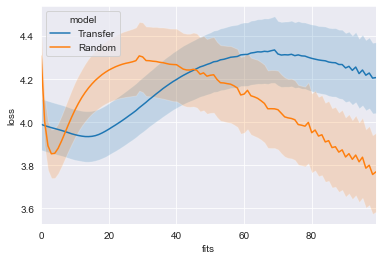

In [12]:
def plot_sine_learning(models, fits=(0, 1), lr=0.01, marker='s', linestyle='--'):
    data = {'model': [], 'fits': [], 'loss': [], 'set': []}
    for name, models in models:
        if not isinstance(models, list):
            models = [models]
        for n_model, model in enumerate(models):
            for n_test, test in enumerate(SINE_TEST):
                n_test = n_model * len(SINE_TEST) + n_test
                fit_res = eval_sine_test(model, test, fits, lr)
                for n, _, loss in fit_res:
                    data['model'].append(name)
                    data['fits'].append(n)
                    data['loss'].append(loss)
                    data['set'].append(n_test)
        
    ax = sbs.tsplot(
        pd.DataFrame(data), condition='model', value='loss',
        time='fits', unit='set', marker=marker, linestyle=linestyle)
    
plot_sine_learning(
    [('Transfer', SINE_TRANSFER), ('Random', SineModel())],
    list(range(100)),
    marker='',
    linestyle='-'
)

## MAML

We now come to MAML, the first of the two algorithms we will look at today.

As mentioned before, we are trying to find a set of **weights** such that running gradient descent on similar tasks makes progress as quickly as possible. MAML takes this extremely literally by running **one iteration of gradient descent** and then updating the initial weights based on how much progress that one iteration made towards the true task. More concretely it:
- Creates a copy of the initialization weights;
- Runs an iteration of gradient descent for a random task on the copy;
- Backpropagates the loss on a test set through the iteration of gradient descent and back to the initial weights, so that we can update the initial weights in a direction in which they would have been easier to update.

We thus need to take a **gradient of a gradient**, aka a **second degree derivative** in this process. Fortunately this is something that PyTorch supports now, unfortunately PyTorch makes it a bit awkward to update the parameters of a model in a way that we can still run gradient descent through them (we already saw this is "Learning to Learn by Gradient Descent by Gradient Descent"), which explains the weird way in which the model is written.

Because we are going to use second derivatives, we need to make sure that the computational graph that allowed us to compute the original gradients stays around, which is why we pass `create_graph=True` to `.backward()`.

The code below also implements first order MAML, which we explain later:

In [13]:
def maml_sine(model, epochs, lr_inner=0.01, batch_size=1, first_order=False):
    
    optimizer = torch.optim.Adam(model.params())
    
    for _ in tqdm(range(epochs)):
        # Note: the paper doesn't specify the meta-batch size for this task,
        # so I just use 1 for now.
        for i, t in enumerate(random.sample(SINE_TRAIN, len(SINE_TRAIN))):
            new_model = SineModel()
            new_model.copy(model, same_var=True)
            loss = sine_fit1(new_model, t, create_graph=not first_order)
            for name, param in new_model.named_params():
                grad = param.grad
                if first_order:
                    grad = V(grad.detach().data)
                new_model.set_param(name, param - lr_inner * grad)
                        
            sine_fit1(new_model, t, force_new=True)

            if (i + 1) % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
                    
SINE_MAML = [SineModel() for _ in range(5)]

for m in SINE_MAML:
    maml_sine(m, 4)

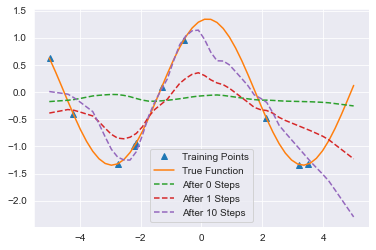

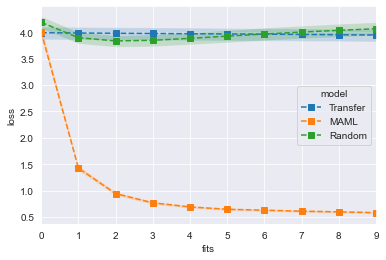

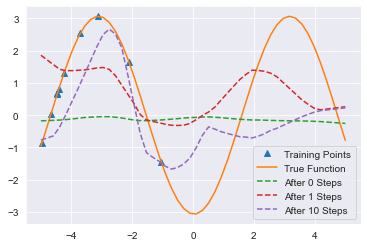

In [14]:
plot_sine_test(SINE_MAML[0], SINE_TEST[0], fits=[0, 1, 10], lr=0.01)
plt.show()

plot_sine_learning(
    [('Transfer', SINE_TRANSFER), ('MAML', SINE_MAML[0]), ('Random', SineModel())],
    list(range(10)),
)
plt.show()

plot_sine_test(SINE_MAML[0], ONE_SIDED_EXAMPLE, fits=[0, 1, 10], lr=0.01)
plt.show()

So MAML works much better than transfer learning or random initialization for this problem. Yay!

However, it is a bit annoying that we have to use second order derivatives for this... it forces the code to be complicated and it also makes things a fair bit slower (around 33% according to the paper, which matches what we shall see here).

Is there an approximation of MAML that doesn't use the second order derivatives? Of course, we can simply pretend that the gradients that we used for the inner gradient descent just came out of nowhere, and thus just improve the initial parameters without taking into account these second order derivatives, which is what we did before by handling the `first_order` parameter.

So how good is this **first order approximation**? Almost as good as the original MAML, as it turns out!

In [15]:
SINE_MAML_FIRST_ORDER = [SineModel() for _ in range(5)]

for m in SINE_MAML_FIRST_ORDER:
    maml_sine(m, 4, first_order=True)

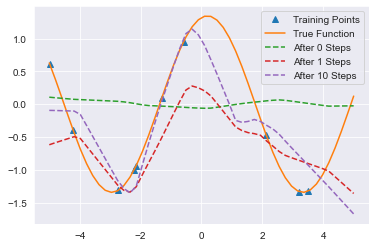

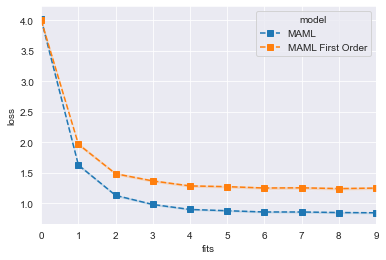

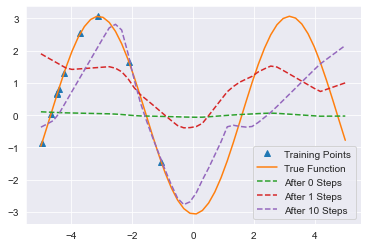

In [16]:
plot_sine_test(SINE_MAML_FIRST_ORDER[0], SINE_TEST[0], fits=[0, 1, 10], lr=0.01)
plt.show()

plot_sine_learning(
    [('MAML', SINE_MAML), ('MAML First Order', SINE_MAML_FIRST_ORDER)],
    list(range(10)),
)
plt.show()

plot_sine_test(SINE_MAML_FIRST_ORDER[0], ONE_SIDED_EXAMPLE, fits=[0, 1, 10], lr=0.01)
plt.show()

## Reptile


The first order approximation for MAML tells us that something interesting is going on: after all, it seems like how the gradients were generated should be relevant for a good initialization, and yet it apparently isn't so much.

Reptile takes this idea even further by telling us to do the following: run SGD for a few iterations on a given task, and then move your initialization weights a little bit in the direction of the weights you obtained after your k iterations of SGD. An algorithm so simple, it takes only a couple lines of pseudocode:

![reptile_pseudocode](data:image/png;base64,%20iVBORw0KGgoAAAANSUhEUgAAAdQAAACfCAYAAABAzyh3AAAgAElEQVR4Ae3dB7hdRfU//A2odBEBUZPQpIMgXSAIobcg0g0/WqihhRI6oYZQhFADBBNFCBqq9CY19ID0FiD0JiBFQJC23+czf+a8+27OOffcfm8y63nuPbvMnj3zndmzZq1Zs9ZUeZ7nWaKEQEIgIZAQSAgkBNqEwNRtejo9nBBICCQEEgIJgYRAQCAx1NQREgIJgYRAQiAh0A4IJIbaDiCmLBICCYGEQEIgIZAYauoDCYGEQEIgIZAQaAcEEkNtBxBTFgmBhEBCICGQEEgMNfWBhEBCICGQEEgItAMC32suj6uuuir773//21yydD8hkBBICCQEEgJTNAJTNbcPtX///tk777wzRYOUKp8QSAgkBBICCYHmEGiWoTaXQbqfEEgIJAQSAgmBhECWpTXU1AsSAgmBhEBCICHQDgg0u4Za6x3XXHNNtsgii2Tzzz9/1ST//Oc/s1dffTX79NNPs6233jqbaqqpqqbriIv3339/9uWXX2arrLJKs9nfc8892b/+9a/sm2++yTbbbLNm03eHBK+//nr2xhtvNCnKNNNMk80zzzzZ7LPP3uR6Z51YFnj44Yezr776Kttwww0767Ud9p6nn346e+GFF7LevXtnSy+9dIe9J2WcEEgITD4ItEpC/c9//pP9/ve/zw4//PCaSEyaNCkbMmRIts0224RBtmbCdr6B2fzmN7/J+vXrlz333HNNcv/rX//a5NzJU089le22227Znnvu+Z17nXUBnscff3x2xhlnNPTK//3vf9krr7ySrbrqqtmYMWOyjz/+OHvvvfey4cOHB2b2zDPPNJRPSxJ9+OGHTZJzAb3gggtmf/jDH8L1r7/+OjOR2X///Zuk6y4nX3zxRZhwnH322Q0VyYRs5MiR2bhx4xpK3xmJfEubbrppZ7wqvSMhkBBoBQKtYqgXXHBBkDyvuOKKIN1Ve+8WW2yRLb/88tVudei1WWedNVtsscWyBRZYIJtjjjkq7yKBYjhl2mWXXQJjKF/vjHMDNsa/zjrrZIceemg2ceLEhl77i1/8IoPvjDPOGKSnNddcM1t33XWzESNGhPz69u2b/fvf/24or0YTafMi0TjQPKywwgrh8s9+9rNuLeF///vfD+VdZpllitWoebzkkkuGiVnNBF1wQz/ZYIMNuuDN6ZUJgYRAIwi0iqH++c9/DkzILJ6E1J0Ik3nkkUcyUhrmGkmZ33333XjaLX732GOP7Pbbb8+OO+64disPBvf+++9nN998c7vlecMNN4QJVDnDI488stsxnXIZ47kJAJzjBCBe70m///d//5cNHDiwJxU5lTUhMEUh0OI11DvvvDOsnVqfpCo977zzsoMPPjibeurGeDNGR41GTYnhrbbaatmVV14Z1MIkLGuBb7/9dnbRRRdlL7/8cka1KM1GG22U/eAHP8g++OCD7JRTTgnPb7zxxhn15/XXX5/Z3rPWWmtlV199dXb33Xdnn3zySXbSSSeFtduTTz65opqMauq99947+8lPftKksaktzz333Oz555/PZptttqC+nGGGGUIagzGpb7755st22mmn7Kyzzgrlo/bceeedM8+eeeaZ2VtvvRXWlamQG8WkSSHaePLss89mykxKLZLr1otJ6lTFym2N+5ZbbgnXqBJh9/nnn2dwnXPOOcPjt912WwarX//619nf//737Oc//3lgSg8++GBmnXyhhRYKUnHxXcVjbegdiMZiiSWWKN6ue6zttS1src0q24ABA8IzJnOXXXZZ5Xnr36TQa6+9NnvppZey9ddfP9TvtddeC5LpAw88kD3++OPZ4osv3gSbyy+/PKy3yx8G008/fSXP5g5efPHF0Fekm3nmmbOVVlop8z7rr8pu6UF+1113XfbRRx+F93iHtProE088kZGY9RNlo3WYaaaZsvHjx4f01NTqSfug32sL+UUMvPfNN9/MbrzxxlD3Pn36hG/FdX3Yt/rDH/4wfDtwYc+g7a21J0oIJAQ6AAH7UFtCW265ZX7XXXflH3/8cT7zzDOLpZpfc801VbPYaqutwv0vvvgi3L/nnnvyGWaYIR8zZkw4P+KII/Kpp546v/rqq/Nlllkm/+ijj/KHHnoon3XWWfMzzjgj/+abb/IPPvggX2+99fLVVlst/+STT/LPPvssv+iii0K+G2+8cX7eeeflG264YT7VVFPl7733Xj5x4sS8X79+4f67776b/+9//8sfeOCBvE+fPvmPf/zjcOz8v//9b6XMK6+8cj7bbLPl++yzTz5p0qTcczPNNFO+ySabVNLceuut+Y9+9KO8b9+++R577JG//fbb+QsvvBDeu+mmm+Z77bVX/u9//zuUHyaHH3545dnmDuTtmd133725pE3uq8/xxx+fv/baa/mLL76YX3DBBaHujz76aJN02kddYPH555/na6yxRqjnhx9+mP/xj38M9Ro1alT+5Zdf5q+//nq+xBJL5HfccUfIA55bbLFFwOapp54K73LjjTfeyPWF/fbbr/KuJ554Il9wwQUr5/rJOuusE9rtq6++yvv3758/8sgjlfvNHRx55JH5s88+G5Ip2/rrrx+O1WHNNdfMx48fH86vvPLKfLfddgvHzzzzTL7UUkvle++9d8DkJz/5SX7TTTeFcm+00Ub50KFDQzr/9txzz0oeV1xxRb7KKqtU7jkYNmxYfsABBzS5VjzR3iNGjAh9+vnnnw+3XPvNb36TX3zxxbl+v+OOOwaM3VQ25davX3nlldAmAwYMCH1S/z711FPzq666Kv/rX/9aec3AgQNDWt/B8OHD8xVXXLFy7957782333778E24ePnll+eDBw8O95XjhBNOCOlHjx4d3ql95p577nBcySQdJAQSAu2GgJl0w4SJLL300pX0GABGsMEGG1SuFQ/KDHWnnXaqMDrpME/P+/AjLbfccoHxff311/FSfuONN4Z0Bi+EcXpu4YUXDuc333xzGGwMVGjXXXdt8h7XFlhggdzgWo0wVPk9/vjjldsYw5xzzlk5d4Ap/+AHP8j/9a9/Va5jvCYW//nPf8I1A7+8MPVGqS0MdciQIfndd98dGODmm2+en3jiiU1eqzw//elP8wkTJlSun3vuufm2224bzp9++ul8jjnmqNxzYIKjrpgggqfBvEyYeT2Guuiii+bXXXdd5TEDvslRo7TuuuvmY8eOrTCAG264ITx69tln5+5F0u69e/cOExzX9LvICDGWSCY5RYa6zTbb5CNHjoy3w6TKxCRScwxVOv10rrnmyjG3SCaDyKSkzMAwVPiiY445pvLtmExqK2U86KCDKkzywQcfDBO8mF9kqOo8//zz5+XJk8nEnXfeGfLXL2aZZZZKXi6aFJo0JUoIJATaH4EWqXxHjx6dzTvvvNnYsWODrBzXKK2xUe01p0qK6j6WuLZ3UI+hhRdeOPyyVKVKpFYtqkt//OMfh/tUZ/vuu2849m/FFVcMx1S9/tpK1IGRrLlRNZaJmrioKpZOvanxkHNU7dlwo53/MVBaeeWVQ67UvMpGXb3jjjuGa4899lhQoVO1U/Ei6vAf/ehH4di/WOZ4QX7ahkq3tYZl3kX1SS1KrYpsTyoaisX31fo98MADg6GTNqcaPeqoo0JSKk5ljvm6aG1UvSJRaaPYd+L14i9DK1t9LAn06tUrqGmLeRTT1jrWTy0BjBo1KvTHO+64o6J2VU4qV8Z7kfRtavdIsZzSIWukjI8YrC211FLB+nzZZZeNySu/1MW29civSLaxeR91M6Kin2666SpJ4EZ1nighkBBofwQaZqgYhLXPAw44oDIgGAx87A899FBYS61mRVssMqOKiy++ONtvv/3CWpp1oz/+8Y/Zb3/725CsyESLz8Vj66tFsmbWGrLuZD30l7/8ZZPHy4ylyc1vT6qlqXat2rMdfQ0+GKw1y8hQI2abbLJJWJ9rpAzf+97/6xbWAcv05JNPhnXI8vXyeXwvq1STsEi77757PGz210TLRM0ky6QNozExiPUsbiEpHsu4kb6x6667hjVK6+bW5/Xt1hCGqqynnXZaWBfda6+9QjbKiaEVy1Y8rlZOzA/GGP1dd92VMVwzcS1PGOtN2Orda0390jMJgYRAYwg0ZkmUZcGwgkHDtttu2+TPXlPE2pcRRT0y0Nskz7jC4OPXYBSJNGEbiT2WRf/BEyZMCEnKg1F8rpFfg1tkEGb30VCmkWd7Upppp502MB1ljnsvbSFiBFOkf/zjH8XTJscsj+eee+5sueWWC9eL2DHuaYRIfAyZar3XoH/vvffWzYpRGcl/9dVXD0ZljKNIvQyQyvmShP01Spi0fckmdJgpYrSDWrr31JYhW5cYyxW1F5tvvnmYDBS/i88++ywYh4UXVfnH2A02sMPgaYUw1zLZ1mOiQgNRpEcffTT73e9+V7yUjhMCCYFOQqBZhspq1UdtiwSLWpv3I7Gm5JSARIMBHnbYYdkll1wSbhuw3UdUa9RMiy66aFCNGSTNuqn/qFlZxLJiRH/5y1+CBSoLYoMe60QDFUtazJd1cBzwOG4oO2tg2Rj3c0oXZ+ushG2bYalKVWgARKLpROZ9/vnnByZEimaVqb5x/yWrYwOuP8eYs/SsMJX90ksvbZKeepPVbD1STnncdNNNIRlL3OJ5rWe9jzoWphxTFBkJVR+mo6733XdfULNeeOGFQa1JMkfKVVSFqhMcEAvrYcOGhTpGjYE85YUinjBjSUqC9C6qUhoHuEUr1z/96U+h78TymcRg+IhlN9WySVUtwkhYkSNtQatADbrVVlsF62JqVmSbkH6CwVA1W1KAS1xSkEZ7cDaiT1pawPj0W2VF+gqNhTrpY7F+yu4baI7013POOaeibZEe06OuPuSQQ4KVsqhNviV1kD+Vrfd5R5zsYbj77LNP5XUY5HrrrRe+M5KrsquDtrH04tuAi+dNUmkETEB8lyaOHHKoo36K+eoz2ilOHiovSgcJgYRAmxFo1jm+gYg0EFVoRVdsBi8DOwkmkg+d6zmm/wY66lAfs20tmJ+P3jaY+IzBgTrPVgADMLLG5HkDCOkB84trRQbuuE1A3gaSqDL2bGQi7pEMqDrju2699dYgvVl7jRv8MTODWCynvJQnDnDKTiLCiCODUT5bS2zbUD5pDc5rr712YFawcs32FddqkQHV4BZVrLHu1jdhVIsMlAZhZUbqGd0mYniYEKaAwZCSkIFYHZC8Sa2ICtW5yQvsDLQmH2UXhjDBqAzY1JikyzgRcW5yZP8vrJWHlKReGKwJjHJZ54zr6NJE7G0XqUZRUqb6xIiV86c//WklKWaMIZkcxPcpJ+arrbQDZoRif3Rse4n2xyhNJEzubANTXpMNSxP6ddy33Fx7yFN7c8cJuzJhivAykVROW2N8U9pEOfUx/Ql2rltKiX0c86VONvkySZBGn4v1koc62PYjbVzzNtn0/cT2oDI2oYGJtrBUM9dcc5WLms4TAgmBNiDQLENtQ97feRSDIVVwoVakI444IkgIZVeBxTTpuGMQiAzVxKmziUSOaTXic7mzy5belxBICCQEWopAw0ZJLc24WnqMk+oYYyUhmFWTHKh529NbULV3p2vfRYA0SkImoZNmBDsg0XQWMWYjDSZKCCQEEgKTAwKdKqECzDoeFZ5oKVRX1G3UiMVtHJMDsD2hDoy/osqe2pF3IZOdziBredTSLdlG0xnlSu9ICCQEEgKtRaDTGWprC5qeSwgkBBICCYGEQHdGoFmVLwOPaKDTnSuSypYQSAgkBBICCYGuRKBZCZWjgHIw664scHp3QiAhkBBICCQEuiMCzTLU7ljoVKaEQEIgIZAQSAh0NwSadezQ3QqcypMQSAgkBBICCYHuiEBiqN2xVVKZEgIJgYRAQqDHIZAYao9rslTghEBCICGQEOiOCCSG2h1bJZUpIZAQSAgkBHocAs1um2lrjfjq5cAB2X7DE4/oHF1FnIVzeceXbIwZ2RVl4ReXX+S2UvRyxEH6uuuu29bspojn9UMxQzmX4LuZb93uSrxZ8eGr39bzC91dy5/KlRCYkhDocAmVJx6BojEPUVo4hG+E7H8VrSNGe4nPYCBlEl9VBJJGyMAkIo5YmJE4zReYWaSVziBRTxrFoVyecv2d8zzFWXqMBFN+pjuda9digO2uKNv2228fgm5zQH/44YdXLQJ/0zGuadUEVS4K4lCOCVxuL4+NGDEiEwy+EcJQObXnPH9KIf3YhDdRQqCnIdDhDFUUFBFf0KBBgxp2hC7yh/Be88wzTxNMxa8skxBwMXpM+V75XH4G1CKJluJdnSWpCIEn3mVrSPivIom0Mnjw4OKlbn0s4g1puqvInmpRdbi7xPwOPfTQqkURuSVGxqmaoMpF0XQWWmihJneq9VeRflZaaaUm6WqdCDMnyPiURAI2lOPdTkn1T3XtwQjknUCXXXZZTuP70Ucfteltnt90003blIeHH3vssXzhhRducz6tzeC8885r7aP5Wmut9Z1nv/rqq4Cv3+5OAwYMyN95550uK+ZTTz2VL7nkkp3yfu2xzjrrtPldH374YT799NO3OZ+eksHw4cPzW2+9tacUN5UzIVBBoMPXUKvNNYQKu+eee8KaKun1uuuuC47Szdrnnnvu8IgYkmaqZvxLL7108NZEtSugtTiZJFhhv6hpxZoUV7KoFhMzVAQVEW04fZ9tttmqFSWUwfvFlVSWH/7wh+Ed1n6LNOOMM1ZiTVLDiZvJoTzpWPkaIfFDxfB84IEHgvRDommUqKrPOuusgJv6I8+XndkL7K4uv/rVr0L0mJi/dUPxRwUnn3766UN82lqRZUSgsb5I9Uait+ZtHU+9p5tuulB2qltxOKnmpCmqMOFCEpV+zjnnDPgLri0eLnW7GK2zzDJLyCe2S8RUOeUXJThrzSR69RTrk/pTPNvYT2L9ir+Ca4tNKi+xRMX+ROKfTpgwIQRDh6F6uV8mcX6lo7GwLi2mq/Ty3XbbbUMZtKV2j88LPajPitdqbV4bHHvssQG32F76q3i+d9xxR/gtRtrRr30T+ivVca9evcrFqnsuT1jRfGhjbShgeoyPGh9WL31b24pbrL+jWH6YiJPqm1pnnXUqgejFmYWDvuN7ivGRxcBlk+A79Zz+p63kjQR+1/YwKdZJH/EN6Ufe2a9fv1Cm66+/Pjv55JOzww47LMT75aktxm2Vjz7n2UUXXTS0a4yrC++tt946u/nmm0OdvE/elnNgqi3VWVzYRAmBjkKgw1W+1QpuIBfpZOjQodmYMWOy1VdfPQwEBhwfDTJwu+eDRK5jXhinYNP+kLwwzqOPPjqc+2dtzIf3+9//Pgwo8n/ttdcq98sH8thzzz0rAaXPOeecEIVFoGcfrnU2Hz8SLcd6JWZmnU1ag0A9MgBQLV555ZWBifjwDQC77bZbvcea3LMWt9hii4Vrsf4xwHhMaI0aI6XONBjGOluztMZsMIcJDHfffff42Hd+pbfujSFIi0yCqMoxPgM2Axnh3jAFbXT++eeHdAZdeGMsO+ywQ5jw7L///mFwgyUmx0hNHWLeBviBAweGwU6gedhoD2Tgfvrpp0N4PxMfgdV33nnncK/aP5MwSwswUDYByA866KCQVDt7t8mC95uUVSPXMbdTTz218hz85RsxxjBggIkh+eojQhGi2F+1UbG9lAGWe++9d0jnH6Z0yimnBIaAgTOUwpxbQhjdiSeeWFFhayuGV3CFOfrb3/6WCZm35ZZbhiDmq666amhL95Qf87G+K42JX1xfxtwwydiHIrP0nO907Nix2ZlnnhkmPvoXzHfZZZfsT3/6U5iQsIUw4cLYkChD+qeJk/bGvE0W3TfB8qfd4QYvZOIMG5Mjkxp5+57gqx/pL+wtLIHof96h3S0FCfruWz7vvPNCXulfQqDDEKjIqh14UE3l+8ILL+Tf//738zfffLPyZmrYf/7zn5Xzgw8+OD/66KMr5+PGjcvXXHPNynk8uP/++/Nf/epX8TQfNWpUvsYaa1TOt9122/zMM8+snFdT+fbp0ydXJjRy5MhK2hNPPDFfZZVV8qhO3XrrrXMqqUiPP/54Pv/888fTqr8bbbRRfs0114R7f/nLX/LPPvssHO+00075FVdcUfWZahdffvnlfOaZZ/7OrajyfeCBByr31l133fzyyy8P55dcckm+wgorVO45mG+++fInn3yyybXiyS233JIvsMAC+TfffBMuSxvVcPvss0++7777VpJrw1lnnTWkHTx4cD5o0KDKvREjRuSuRZpmmmm+o/Lt169ffu2118Yk4Vf7XXXVVeH4wQcfzGeZZZac6vPTTz/9zvPFB5dddtl8/PjxxUv5csstl99+++3hGpXvL37xiyb3q51cffXV+dprr1259eWXX+ZTTTVVPmHChMo16txi+51zzjn5wIEDK/fvu+++gGHlwrcHb731VsArXr/++uvzBRdcMJ7mQ4cOzYcMGVI5b1TlazlEGSLpF4sttlg+duzYcOm4447Lt9xyy3g7X2+99XLfVCTH2txz77//fmWJRr6+g0izzz57PmnSpHiaH3vssU2+y0ceeSSfdtppQx4xUe/evfOJEyeGU/XT9yN98MEHoX0///zzcIlKPva1mGaHHXbIjzrqqHiaP/vss/lcc81VOe/Vq1elLXwnaJFFFsmfeOKJSpq///3vleN0kBDoCASqT9E7jH03zZgalbonktlmNavIeL/RX7PjLbbYIsxYzXqp+qjrGqVNN900JGW8Qkp58MEHKzNlUggjpssvvzykkb961CLpSURxVq9+ZvXIL1Vfe1HRIKaIpTKQYGKZvY+0SNKsRWb58qCudOw3GsfIj+qsmF+fPn2C9EoqGjZsWCXbfffdt3Jc7eDdd98NeZelB9LvxRdfHKQLz+kn1MSorOaO+ZJeSVdFHNyLea222moxaat+SXrFvIsYtyrDbx+i8SAtXnbZZcFgixV4aw3kokQna8e0PvKlFaElgTfpjlSn/cvfBUnOc+IUR/K8MpEio4q+/BxDq0hwEee2mEcRK/2H1FrsP95Lu8EIqxp5hmQan9EWZYy0M4rLAaR0xmU0O5YQjjrqqGpZp2sJgXZDoEsZqo+stcRS1PNUPGWy3nPwwQeH9ToDIIbYErLuZ7ChjmKlacvPY489FgYB6lADs3WkSFRotchaXmSm0hTrbD0wqghrPV/vunUvA1GkYt7xml+DjwEvThRcKx4X08ZjeZmYjBo1KqxZYsgxf/lZqyvmEY+tacV0Ma9av8pfizl6xkQkUlyzi+fVfovpy/fr3SunrXfeaN3KeVjPo+qN64HF+w8//HBgeH/+858zVvH6XnkNv5i+JcfUpt6NqHxNEDElE6C4nFLMj+q3TIccckhQ42LE1lx9W2Uq41I+L6b3DS233HJV+08xnePYxz1jXbRoJwGrIpXLvtNOO4V3mBiPGzcufLeWDxIlBDoKgS5ZQ21tZYqzb9JIrbByGIH1pChNxHVZhjKN0o477pj97ne/qzBDa2rIB82oqEjjx48vnjY5NuOOa3VxcJDA4GaWHo1GrBFZO6xHxfpL1+jWAmty5TIzqpk4cWK914U1U+vRJhXyiFQtP4ZD1opNHsrvKuJTrIP9syYr1n3LAx0jqP79+8dXNvRLQrGfuD3yauiFzSQq1pX0xVCoGllP3WeffSpbqWJ/xQjaujcaxtrLRMfea2v+mCmK76n3XSjz6aefHgzKogFTI89Vq2e8Vu0bso5sjR8VcVN+VO2ZeC8kqPLPGMCoKa7z62uM+xIlBDoKgQ5nqO+//37FiYGBzkdj4MUQfeQsKlnfMfZhSODcjFo6DNP1+AEzMMAE3OcYgVGDY2pTAxZ1FqJukj9ipEIta2DCRLzT7N+75E3aYljiHfJRFqotBj0nnHBCyAMzJU0i11gyxkGbcZUy1yLGPyRmzNIAyZjpwgsvDIYYfiMZMPzVI4Y+JHJGH6RuVqbKG51EUMupK+nd+9SLipn0SO3FyAuR1qhT55tvvnqvC+o9Bh2cc8w+++yVtIzJGIJFyZ/kxaqaFMmQiZFJZPbKSuUeyQRCfvCNVp/Uvf70FcT46Ec/+lGQ2rSXdjEQ6g/6Ti0iFakjBhBVkurJEhe2xbbXZs6rEXy0Kxy9tx7G6gFj/ccxLCJjMKHzvHwwDPtay33f+4v9VR2ll4/2tCwQ21W/JanVI5bc8f0mQpYnGIdR8VLXxu+CapxEF78LdVBnbeU7Umc088wzhwmhe4jqdd55562kY6Smn/mWYB4xhofr8onflzzcHzJkSMAqTrS0uwlZVOH6RvQRZYpS53HHHZfdeeedoZ8pB6zVJX6/0pqwKk8k2p/YR7UDVXBcNohp0m9CoD0R6PB4qAa4orrOwGyg8XGQ3HxgtqtQQ/l4fIDUQQa8yCCpKzleQKQfAzaVo+0TJBnXzGq9h5oWc2V5iPmYlVo/YYVo3U86z/v1bpaLBl3PejfrUBaOGK40BjCDoDJEk3v3qJAMUiRQUlk9FZcBEpMwgFjTUvYoPcfGVAdWi8cff3y8VPXXoGTriecxO5MEamVYYqYsIZVfuf1Jp/6OWSPDlZqVuiwOYFVf9O1FEopBizRdJAMY3GBmkCLNwwsV8bH2WVSPw4JFsMmBdb1IBnaSkjyo3GHq2MTFYKt+6mCt0YBejwzgBn7tYxCFifYx4GL0MS99qrj2F/PEbEwQPI+hSEc9GjG25mmCBRdlwrAjI5GHOrNiRSZ02p4UbjuM9vOsvPQrmhCTQtbD+qC6e9Z3Q+JWflqCmN7kqLg2GcvsV5vqo74xbWBSQsqP7WKSZeuSPmsypU3POOOM8BwGrqzSalNSbVxOMWGDpwmQSS31Pw0LTZBJYpwweR8s4velfr5t6+rx+9IXpVFn/divfqjs6ohMaNTfeMCSPtocmCj47rSlOur/+qE6yd91KvW4Vu67IFXr8+qlHypjooRARyHQ4Qy1owreE/Pl5ci6TlFifxcAACAASURBVC1q7n6t59L1hAAEMCXMuN62ooRUQiAh0HEIdLjKt+OK3rNyprazvleLqLCKBka10qXrCYFqCDBkoq2IKuhqadK1hEBCoGMRSBJqx+JbyZ3qFMOM6qvKjW8PigZL5XvpPCHQHALUntTO1NAMcVjEJkoIJAQ6F4HEUDsX7/S2hEBCICGQEJhMEUgq38m0YVO1EgIJgYRAQqBzEUgMtXPxTm9LCCQEEgIJgckUgcRQJ9OGTdVKCCQEEgIJgc5FoFMZqr2GjHPsE02UEOhqBOzbteE/OoHo6vKk9ycEEgI9G4FOYai8l2y33XbBYT13YDast5ev0iL8NuNzFhA9xRTvddVxdyxTc1jYLM8zTUuIhanwWRzjH3DAATXd7LUkz45My7OPUGCcJChvooRAQiAh0FYEOoWh8sbCzR5vSLwE8YAUvSC1tQLF5+3D42gcQ4iEufLU0hkkKkd0kxjfV61M8V53++XFh1tBgdxPO+20FhWPS0ZeoMTQFBPTMReN3ZW45BP/M1FCICGQEGgvBDqFoXJdZv8ln6V77bVX8DMbncK3V0Xks8YaawT3ad4TiWu0on/PeL0jfqPLv2Le1cpUvN+djrm544uXu7eWkD203ONFv6t8DIvAc+SRR7Ykm5Q2IZAQSAj0aAQ6nKE++uijwQE3n6d82XJ6HR1UUxNyHE96xYz4EI3E/yYJ4qqrrgrXJ0yYECQeG9drEamX71f5Ik63SVzOSY58ixYpMoJilBfHfJryJ0otyC9sJHUQ4UJs0HJenHDzUUs69i5pUblMMS9O0DGhsuqbRKsO8ld+KmN+Wbs7mTQV68JfbHvGem2v+utXfCbDvtyGxXeYiOmX0nanJYRiGdNxQiAh0L0Q6HCGKsoGYyROsG+++eZK9AfqQA66ueRbfPHFgwN05xguElVGHEZRQoSc4kyfk3MSbjViYCJKDCfkMYoM59uYEQYormcMwYYpDxo0KDhKJykLvBzVkyJ0iHbhWU6+BeKmCpWPAMVCX3HszhONGKnIIM3pOmYqZqR3YZjFMjmPJB+TBc79qaj333//wIA9P3LkyBAU2UQCk8aYlTFGlIl5lH8xcWVs7i8y+vLzbTnnAcpEoG/fvpVsTICik/LKxS48gA9ft/44UTfJ0gfKpK31R87qtT3thnOTpUQJgYRAQqAuAnkn0A477ECszD/66KPwtnfeeSefbrrp8u22267J29daa618jjnmyD///PNw/Q9/+EN4bsiQIfknn3ySr7LKKvnJJ5/c5Jnyyc9//vP8pZdeqlzeYIMN8gsuuKBy7mDkyJH5JptsUrn28ssv5717986//PLLcG2FFVbIhw0bln/zzTf5JZdckn/xxRf5gw8+mE899dT522+/HdKMGTMm32qrrSp5SKOOH3/8ceVaPFCmF198MZyef/7536n3fvvtl5944okxeT733HPno0ePrpzvuuuu+emnn145r3YwdOjQfK+99mr277nnnqv2eJNr99xzTz777LM3udaSk7vvvjufa6658rfeeqslj3VoWhhqn2effbbynsceeyxc22WXXSrXllpqqXzeeeetnDs49thj86mmmip/+OGHm1xPJwmBhEBCoIjA/4uXVJfltv9NxklUqmVn8c5JitRxxYDWImjMOOOMQWXcHqWhyhMfNEql8qTWo+4lfSIh5Egym2++eThnEUp6EQZK+allSd4tJRKwgMdFItmxND3wwAMrl0nakYSmsr2jHh1zzDH1bnfaPeVkmCRUXMSy015e40Wkcm0udFcxbF4MaxYfEwqQRiWG6YvX9UtaDVLrUkstFS+n34RAQiAh0ASBLmGoMZB0k5IUTkTOKJKYlO1B8rVNwqBv6w7VbiTMsvgeMR+LRGVINSt+5p577hmYbVRPF9PF4/iueB5/MWGMukjOxaMsklicLSHq4uIadK1nxUJtad618ipfN0kyKaAeZeBErRoNlcppO/Oc6l37NVeWcr8rl7G5++X06TwhkBCYshDoEoZqSwXCxIrkHHOJ94v3WntcZF62zwjobP2TsZHgw5GscZIEy4w03icBTjvttGGfpWvRoEXAbOuH5UDV8V3x+fhr3TQGZI7XvNt2oraQwOTNSbHytwZdLmtb3hufJQXaY2z/arSy/stf/tItYnNipNahTYBM5mLg7Fj2+EsrYFJVrV9KkyK4RKTSb0IgIVANgQ5nqGb1pCdECsO0MEyOHv7+979nQ4YMCWo4BjhUsAyRhJ+KxjWew7R4sykywGqVoZYjpZFIIjF0EiMSRQvhgw8+ONtoo42CypZa0nVqXJInwiwZURWJZBmtk6WnHvQeVrwY2fe+971srrnmCgZKvXr1apK2WCbqUHVX75lmmimovi+99NLAjLxP3vIt1kF5mjMmak+VL0Mc7/de7RXJfuJTTjkl1F3ZiwQ7avPoEMLzEW/pllxyyRD8+qSTTio+VlH9w2W33XZrck+7/fKXv8zGjRsXDNKKNx966KFs9dVXD8ZgSyyxRPFW1eM//OEP2XrrrZedffbZQSWtfUeMGBHSalttSCXs2i677BL2Lm+yySZh8kPiXnPNNbOtttqqat7pYkIgIZAQgMA0RzE57UBi9YoZkhBYzVK5zjPPPGGNlNrVfYyVS0JS1k477RRKc91114Vr1LK2t1AfsrasRQZzz2Nqtr2w0CRtWAu96aabwhaOVVddNZt99tlDGdZff/3svPPOC1bGDzzwQNg3iUnw9INxshTGyOM7TQKke/HFF0P+AwYMCAxZGsyZGnWllVYK62wkTuuk1IyxTM8++2wok7r369cvs5b6/PPPB8vnfffdN7N3U/rhw4dnvXv3DuUi6bGMVhYMAKNTr44ia8isjLXFwgsvHCQ6ZVxmmWXCK0n7GA+MTRoiwcRkyH1qX3/aa+211w5r1dKpG0l+gw02iI+FX+uYXFFijpwtFIlkaUK24YYbBmZXvIfRm3RZa6+lVSimp4Jm4Ws7DAtqfRGT1G/skVYGfVQ76BvXXHNNdvHFF2e33HJLtsMOO4SJAg1FooRAQiAhUAuBFA+1FjLpelUEbA/C8E0MWkpjx479jkFWS/NI6RMCCYGEQHdFoGWWL921FqlcnYYAZw2tYabU/XPOOWenlTO9KCGQEEgIdDYCSULtbMR78Ps4sKDaJqG2lDjVWHnllVv6WEqfEEgIJAR6DAKJofaYpkoFTQgkBBICCYHujEBS+Xbn1kllSwgkBBICCYEeg0BiqD2mqVJBEwIJgYRAQqA7I5AYandunVS2hEBCICGQEOgxCEw2DNUezehIoBEXfD2mhVJBEwIJgYRAQqBHINDjGap4q7z02OPIk49QbwcddFDwYNRVLcBbEA8/nFN0B4IJhwV//vOfu0NxpvgycH/IgYmwd0V3kcL+ld0edlewOO/YY489ggOQ5kILdkQdTJo5QeF1jEero48+OuPqcnKma6+9thKCsrl6ckjCsUp0lNNc+intPtez+MTvfve74B6Vtzpkn/3uu+8e+tR+++0XnPm47pvV36U/7LDDKq5nv4NbMfRMTzv+73//m/ft2zf/z3/+Uym6MGnTTjttLkRcV5KwcRdffHGbinDTTTe16fniwzvvvHN+2mmnFS+l4y5E4Ouvv85nmGGG/L333gul+OCDD8J5c2H62qPIQti98sor7ZFVCNP39NNPt0terclkzTXXzIvh91qTR095ZplllmkSMrK5cht/jEP1qD3HmHrvqXevq8rgm+Pt9eabb25SvMsuuyxcj2FE483nn38+P/744+Np1d8eLaFyd/ezn/2sSZSYeeedNxs4cOB3Jg6dfYFv37YQV4N33HFHW7Jo8mxby9Mks3TSZgTs5y1G/eFHmO9iwQs6mrhfLErGbXlfV/Yrvqa5kOS2ckog40FLAt030jbcsnYl8aNNy9gVxMUs16dc4xYpRpXiLrVIsCLV1qMezVB1mFtvvfU7ajI+W8uhuoBWdnhfD5iOuGeNl+qgkTVealp+gquR5+VTjbyDT16+dP11J+I3t9xJY/n40m2v9on4lAMKtAc2PrZi4IJY/vb4FQWnGB2pNXnyb8yXdC2C/6mnnlrrdqibOkZ7hJoJ69yo189hJ6CENMX+qa1cd794vc5rsgkTJoT+tNpqq9VL1qp7MMCwu4q8v4wDX+PN+ZOmytQHGqH7778/jJ+NpG00TbVyx2erfeN8nZe/05jeb0vbQV7GP21Xxq+Yr2Pfmm+uOM76PiZOnBiSFq8//PDDYdmsue+zbWJUuYSdfG6NQPBnIdEwUeG11lhjjSYzVh+ptYef/OQnIXg0RnTyyScH6QBIhx56aPgorcFw3v7EE08EoDlE1+EMzoJTX3LJJcFB+w033JCJ7MJxvfeLL2qGJarNPvvsUxMBaxpCunHmbqYjaLq/anTZZZeFmahJgfVYEXGEnUN33nlnkGRmm222EFiARBPDihlgRO0RBJurP5FVikHU47sEcD/iiCOC03tlLgbdjmn8PvbYY2FGVh6gBTgYP358MWndY7NQAdQFBRAoXrADEX84uH/yySezv/71r6EN4e9d2sRkSaAC6+JnnnlmcGIvUo11aY7rRY+xhqZ9MAh5iDpjLYQEBtsrr7wyOLbn9F5gA+HbhGgrYgMj/UGAA32Jo3zrKFtuuWWIThMrdvvttwfshdmbNGlS+GBje4sBO3r06OyCCy4ITvZ9dCQJARA45UcmC8orOIO/MrEBOPLII8P6jbi78BWBR7+1DmYw0rawt4YTSXAJuOkrghSQ1s4666zs6quvDtGMYjq/+j7cBDxQXq4gBSuIwexhAU9ru/q+utbqo8V8i8faRnAFQSmefvrp8H2I3oMEG8BIBVcQoEB/FaBCf9RHvNcasshPvoHmiMQmiEN7urTk0cv3aUxRFpNAkaGQbwZGymzgJd1Yt9U/a4VEFLBeBCN57bzzzmEM8bxxQ1wSg778tbN0BnH90VodHH3nojDddddd4ZvhpQyOSBQv38piiy0WIkAZk+ABv4suuiik8c/4p7zqpj/GtcFjjz02fAsxQpRvUp3KZHwTNMPYaBxSD21r7KERPOGEE0IAj9NPPz2sPfrOlDNqCqX1jv79+4fvRh19O4QG37PoYvqdsm+66abh9ca52267LbSDfm3NXrkxTM/CXVAVecvHN6ucvk0BRIwjxm3fQT2Cb5FxGj8GDRoU2sB1YwIyplhDbZaqKoJ70MWXX34532STTcL6E3249dO//e1vlRoMGzYsX2655Srn1hQuueSSyvnDDz+czznnnPl9990Xrn311Vf5rLPOmhfXsgYMGJCPGTOm8syFF16YL7744vmXX34Zrn3zzTf5iiuu2OSZ3/72t5U11Oeeey7v06dPHnXyn376aT7PPPNU1s8qGRcO6OqrrQ3NPvvs+dixY0NKOv2f//znlafWWGON3NpcpCOPPDIe5oMGDaqsod5www35mWee2SRtJeG3B2+++WY+ZMiQXNmtRx966KH5v//97/Bn7bpRgo21n2uvvTY88tFHH+U/+MEPwrrFu+++my+yyCJ5Mb/Ro0fne+yxRyX7jTbaKN9uu+3C+UEHHZS/8cYb4XibbbbJYYzUc9KkSaENF1100dw70euvv54vsMAC+WeffZavvvrqTepbxGa33XbLBw4cGJ7xT7mKfeLJJ5/MV1hhhUq+0hx88MH5qaeeWnlmpZVWyvfff//K+SGHHJIfccQRlfPNNtssP//88yvnb731VliniWuobgwePDg/8cQTK2m0U+/evfOJEyeGa/qN/h37nbWnX//615X066yzTuin+nA9kudjjz3WJMm5557bpPxu6tO+j3o033zz5XEN9Z577smtaRbJ2v0FF1wQsNc/I2mjo48+Opz269cvXg6/xbZpcqN04l3arr3I97T00ks36SfHHHNMftxxx1Ve4Z2+pUjHHnts+E7iebVfa9azzTZbpd2MLfvuu28lqTb/+OOPw3cw11xzhb4cb/p2Hn300XA6bty4fOONN4638q233jo/++yzw7n+NPPMM+cffvhhHtv/8ssvD/3YGIn0tZlmmqnSj2+//fZ8iSWWqORX78A3MeOMM+Zvv/12JdlRRx0VxjQ2LL169cpfffXVyr1f/vKX+VNPPZX73ot9WL8zTr/00kshrTGuvC6pPy2//PKVckp42GGH5SeffHKT/L3fN+G7g1+5H7nfHPlu99tvv5BM+a+77rpQJ2V0jK6++uomdauXZ49W+ZotmHGZkVkTsp6y9dZbhxkUKQiRNMXwNAMyM48SUpxpRBE+Bvg2Q5PGDDUSXbsZdJHMsuMahTzMnsz+q6nKxowZE9QFpBSqZ2ot5SYht5T+9re/hdigpA2zZ6HdbBlCwp8tu+yyYTZJmqm2HkdqIu2wjC6u4ZXLQdVi5mnmLfQcKZZ6xF8j4dJifmaa2mLdddcNl8S0JX2RpEhxZqXF/EiKyhhnjbCNAeeVJ4Z4K14306chID2Q1qm84Cx8nzqatXqO1CRNNWzMkiORIMU+japREoh8Y1+RTjm1d1RXuRf7kPvFPiN2LsmtGE+V1qGYn2eqncOb5IZINd4X1f0vvfRSk7B2pALBC6pJGSGDOv8Ehxe2rkhrrbVWdtpppxUv1T0mYXmmSKQSeWsHa8TOSRfaJM74fTPUtqRmGotq/baYp+O4flpN3Usaaw3pG0IwFr8L5VWvqP6t18613unbEVAirlf6/klXse9oV+pc12ga9D/9158+RbuFyv2D5EZjgfQnEit1Z7H9fRdRS+LbM2bE8SI82OA/ZaJdizsFlE2dqKBJdWwA9PlYblohWh3SNCkw9mG7H4zT9QJs0LD45ov11Q4kd+M4ck8a2LkOP+M2f+E0ALRrMb51vSoWJVTaR9+AOsnLGEQyhmmfPn3qZVO516MZqoaJHZ36EBPEvHwUccuKwZq6lnoDU5SuzPSqrUuUr5WfqSD47QG1k/WLah+zQQ4zpXaMf9R2VLMtJR2Jioj6OHa4WDYdSacXkFvs18GDBzepqw6DuVETxmdqvZ/aJH6Y1Ca23bSGTGJ89DEveYhx61zc2vJat3NqMMwiUq3A8uXrcDZgRIz9YoYmP7DBBE1IYENtVA8D7RknZbXKaTJjAIlUq8943r3y/fhcvd9qz8RyC5iujBgszKgVxeFtKRk04F2tLUymGqVaOMU8qGi1BdUgNWXc5oKRmOyYSIm9Ww5CX+399dZPqd5bQ7XKb2C1dBSp3CaxPeL9ar8m+tSwxiuMx/IEPKgp4zgQJ0PF/ut7jmrQcr7aOo5zVJ7SUcEWqdym7jVS3mIe8ZjqWRt53nIKtTRSbpOQYrktmWCC+mdxicOYVRRWYt7F31rtYPwuGtOVv3/LPia+JurGGCr65igyVGUvTojjdRMCdWmUejRDNQjokGUipUVmQ+evQUkxZjSxEeLCc/nZ1p4bzMxizJjKZPDQsc3e45+1Xut1tSiW332d18CtzNtss02oi3U1AdojuWdgsg5nvYUEgJkV67n55psHqUoZDWqNkhly8V2NPied2bkBqWwggPGZtZYNKEjPJj1xVt2Sd8GZVBox9ot5yg+GRWzgEhlmtXeIrEN6RrXKiel6X3NEyjehIpm0J+k/rA6tN5okmUxGSaDee4p9C/ORj75brS1qrQ1Wy78WTvLQ/ibA1uJoZjBE+26RiR5p36BGmtdW+kc9qrV+ar2QFIRoR0yirBPHP/drkXJWw8CEsMgUaj1f7zrthHf7RtleYIYYrLW5GIXJJBZOxf7rmJaiGpGiaOAwOd86hlKUrqs9U7xW7Acmhww865Hxk4DCLsN4FMdS352+XS43qdX3L+8iYchRSi6WIU6EavUja8QmI7UIvoyc9DPft/ZnX1CPME6TJevDJjmRYG4NWx2qjekxXfm3RzNUlaEGjKoT5xrroYceqsyeLGxHox33zKaQjtwWIo3G98qXuooRSbGDxPwt4jNOeOutt+KlYIjBOKYWaWhqV4TJaFRl1qkis7EgH5mye2Zm1BPIdiL1jmrpcPHbf8rKSKDaZKSYzrGOaUZelDBjGvU3K643SCnDkksuGaTm+JyPn9ELowWz0Vhm9zEHeKlnS4lEzsClOBjLz8dLGopqZNgYHIrYYKCRpLv++usrxijyNakoTgrki5lVwyXmE3/Vn2oSo4iEmes3/lpLBn8GIAZkOBfLVy/PYt+KGh4aE5qcSFRrVJSWMholhmdU2/G78BycGM7Ij4FZVNnBJE7SqFqpKxEjEOrC5shgWVb3wsKkCR6cTZhUYjLaWjn8Yay1iKrZckQsi3SWkxiJVZP0auVT7bo+R2qiHjV5Ib1FVW5M7xomZbIQyfdholGN9FmMTX3lHZcCqqWtdq3YDzCVeswqPr/rrrsG7Y73RYqSqm86EmZkzDORoLUrjrfGZOMnKpYh9kXfmzQmoZG0A+O/4jcb78VfE7Q4ITJG0lRWG49jer/ebzzaeOONi5fDdd8oDUFLaJqjiG49lMwqdEAfAeZAJWAGzHMKMJEPNKopNDgpDeOJapZzzz03DMAa2EyLukk+rMSopwzQPl6DPknHLFJnwcw0lg9XfiROjABRM0YGanZrxsxa0izcR+DDJ91Qb9UiszQDsBkWKcgAZLYXZ/fKg9EalKh9rFF6p2uYoEkFy0HlwkxgZKYIL51SB9dpMWp1qkVm1NYnzKrLZOC0pmKiQBKoRdoDEzc4UP/B10dohk1taZ2OtkF5qB9Zw5ppRxyVm6onqp21p1mo63CgLkSkCB+6NnTPWil8YIlBFrGBf9y/CD8zbBMYEpL2HDp0aEU1BUfvtrZDEyG9NaC99947vNes2EcJB2XQDiYZGLNBwbM+WBJJ1By4R5Xuo9UPlE/9TbK8T17aTZnURT1MgkwW9FVrvgYDGJEYSHkkVFjqK3HSVa1NrKuRaPXFDTfcMAyktDqwxBD1aapxavFa6jntxApb2ZTH+9SDytHAJm/9lxpt2223DYyUZa92lD9pCCZwjNdhyBIVQy1KC8U6eM436xvybelPvk/SDa3L9ttvH8pMwojfuDphpL7fegMsPJUXpibeMNWeBnLEFsMarzbybmOAOmpLTAOGzRF89AffoO9hwIABFelXnzdBVT/1Ms6YDGoj65GWcowH0mljzMPwjQHrk9oDFhiz79tkQv/BLL1XPzVZsJbtm/Cn7XxL0kTGWK8OtDb6bdHS3KRSueGmPys35mhMMhHBlHyT3mWcJuXG8Vl+rHHVxTqwMplM60vxe/NtsA/QH405lu98h/LzfcXxSzv7xpXBWO+baW5ypg30ceNkkbS9nR+9evUqXm7+uJ7FUne/x4IsEktUVmVFi9F4r71/Wfmuv/767Z1tu+UXrVzbLcNmMmJ92FOoGjYsRYuWnD2lLv379w+WzMXyPvPMM/nKK69cvNTtjqu1gULWut6WCrCEHjlyZFuy6JbPamdWvmViIc2Cf0qmlvQjPCRazRcxs6OhNdSjVb5Rh2/aYFZjplK0GG1+OjF5pqg3C2/vGpNqehLmnYlNe2Ndzs9svGwgY82nu7dHrTaodb1c75ack6biPtuWPNfd05I0SarlJYOe0P4djW1L+lHU2JXLVGvdupyufD4VLly+mM5rI2Ddg7qMSpiKhBpiSiZqFiqmnkrUu1RjmFB0tN5T6kKtaomDCtfAQJ1KnWe7QNxe1FPq0lHlpDplbNTIWndHlaGj8qUKpeK1pIS5Wk6gomaN2xKm0lHlmxLzTQx1Smz1VOfJDgFrSwbVRFMmAuSixES7vu0TQ+36NkglSAgkBBICCYHJAIE0pZ0MGjFVISGQEEgIJAS6HoHEULu+DVIJEgIJgYRAQmAyQCAx1MmgEVMVGkeAF6nJibicS5QQSAh0DwR6dPi2IoQ2hdtQbmGepRuHBdzzcQLAPVcjLuKK+fW0YxZ+NuOzZuSNhuWfDdU2wtvkzGCF8wKbxG145zgANja7o0MOOaTDqiw0GatolrTKxwkEZwQxvFN8sTrwuWtTuE3eNoVzlsEhAotqW6NYNdrkro7qVPRg07dv3+BqMOZX/mXRW958b2M459pI2Rj3cFLA92pHEEtc1rm1HBeU38kJgg3zvOBw9FA2PNJ+PAAJX5goIZAQ6GIEWrN5tbs988c//jGEXYphipRPOJ+99947hLt6//33u1uRv1OeGKLpOzdacIFji2LYofjoWWedlU833XQh9Fq85le4LWHLYli54r32OtY2QlxF+uCDD0IotaFDh8ZL4VdosyWXXLJJ6CqhmYS5mmGGGZo4MBAuSqiqESNGVPIQmkq4JmHaiiHRYoIJEyaE+/G8/Cv006abblp1k3c5bVvOr7rqqhAOryV5CLNVDEFYflaYvRdeeKF8OZ0nBBICnYyAjcE9msT8M+CK11cmg7f4f92doWIQxdia5Xo0es7rB4Z6yy23NHnkT3/6Uz711FM3ifMowahRo/L//e9/TdK294n4pGI1Fkn5igxVvMHpp5/+O+k8Y2IkPq3YpkUSX/Kcc84pXgrHmCxPQeV6iav6ySeffCe9Czyl6CcxzmzVRO100QSjpSSmL6ZZi2BTzWtOrfTpekIgIdAxCPT4NVS+LIXXoeYtE68hv//978uXu905NSdVY1vJ5n4qQL5FI1Hz8uMr/+hs3z2qRKrNoso0PtOev5x3e3+R+M3kSzeSNuQLlJq3TPwI8wXbKHFwzpcuH8SRLAdQI/MdXI34PeYjt+xsvVratl5rjR8VKu4Y4KHa+/kbpS7njzVRQiAh0HUI9Og1VM7POcjnxLgWCXcWI7JgKLwccT7OGTP3UjHos0gYHCLzfGR9zloXR87OOXPHgDjD5kiZo3skuoZAtvvuu29YF8O8OM72jLyl51DbNc7S5SuWKQfsHOVzcG19jNNzTrm5E+OgP0Y+4GRaBBAuFdUTs2jOA473Fhmq9TXrkNYPXecAHIkkEgM8sHhH9gAAFuRJREFUhwsd9E+YKu/H1NZcc83g9Jpj8Phu+HH4L3JLLTIpanQNXN5czVm3jXEMMXShpWqRdVlBFFrsCLtWhqXr+p1oGRzKCwrNibt+V5xUlB6pnIogI9qIiCn6B89UnH+bgHD+HYkjcumskSdKCCQEugiBjhF8OyfXSy65JKg4b7vttmZfaJ2wb9+++auvvlpJyyF6UdW65ZZb5ptssklljeuMM87Il19++fzuu+8Oz7z00kv5HHPMUXnegXW/Aw88sOLYW5l+9atf5db/0EMPPZT/8Ic/rDzz9ddf57/4xS/yO++8s3Jt++23z0855ZTKuQNrYossskhOHYweeeSR3Dpfc46fPRPXLK0lXnrppUGVShV87733hrysyVlvbY5gtcMOOzT7N2jQoJpZffHFF/lmm22WTzXVVKGtYHH44YdX0l955ZXh+o033li51shBLZWvZ62FLrDAApVs9tprr1yda9G6666b77TTTrVut+n6Aw88kA8YMCAsSVxxxRWhb73yyiv5hhtu2FAgh/Hjx4f+pP9ScetXvXr1yi+66KIm5aKuHj58eJNr6SQhkBDoXAR6tIQaHYMX4+bVmpeIQ8jKVCzCSFSJiy++eLbLLrsEq2DqRVJDjMUpfBupIAYAdk6tRrqNEhPpl6owuv0SHk6YJP5hWRlHiTC+k5VmI87LSczUfPE9pC7SDUm5XtBn74sSKrUnS1qSMXLdsfBujag3YUWibwtRQcOelE4SFKJMeDbhx4TaqtWGpDnhmTxPTUplC/+Yvl6ZaApIqpGEeqoVJFhaIcPOOeecmLzdfmk2+AcWSsvyg9BbsW9pVyG3mrPOFZqLJEri3nHHHQMeNBdl5936rhB4iRICCYGuQ6BHr6GKqWeArTeQ2J4hVqFBsxxA1yAnYgd1aiTXilQ+d6+59U7MohhQt5hfo8fUoBhgDIzsl9PzyGBr5RMZKnWzgRgDx5Q8F/PD9DuLlAOZqGyxxRYh1qOYnQLDI6puzM5koUgYqnYR+1AsRzEzGw2gLa9VV121kp32KjLYyo0sC3E1TZCqTTAwsbYQdb9YsNX6UJz0NJe/9VMTCuu81OOozExdsxbeXL9s7l3pfkIgIdA2BP7/aXzb8umSpxkiGaQZ9QwaNKhqGUh01s+ktfeySHGArmbQVEzX0mPrr9bkalGUGKvdt44r6PbPfvazEHy5OQmmnAeGSjIygYgBz6VxHRbWaKsNyOV8nItccsQRR1S71eQaKb2WhGcNuBzDHkOPDBWzsUZqD/HgwYMrkr7r9p6SvATObnQdlVRrjVrg80jqTtNQjUiA1dZPBbCORlL2jQpgXWRYAlbXCxDvXSKdxDbAQGM/o+Uw0Vh//fWrFalyjeZlwoQJFUndpESb2C9rogSbSCaNjbZrfCb9JgQSAu2LQI+WUEFhU76Bh1ODMr388ssV6YB6kdFGUT1MemUoQ6JsC7EQjYSZGQSj0wKWpcXN+Dbov/nmmzF5+KUCJpGheE8IJlJZcRDHbOP9JhkUTjAP9Swb4bh+8803N6tiLGQV1OMYU3N/tZipvKidi9bFrtEoFMt34oknBil69OjRxdeHY2rSRomkSc2uTxSZHbV+WQKOeVJDl6VTDG/vvffOVl999eCQQrkYoykL4yB/88wzT8wiGzFiRLAsrlz49sAzGCBiGEWFT9rcfffds7PPPruihpa/cpSJQ44FF1ww9GH9iHra5OXGG28sJw3v4cwjUUIgIdB1CExzVFl86LqytOrNBhoWj6xmqcVY8JIArU8988wzYZ1OxmbvpDMWltIYrFje8hZE5YghX3jhhUEaYO1JojDoUb0axAygBmoDn/XShRZaKMSgjEyAyg2zPOyww4LV7gorrBDqo3ysMjEV+WCSpKgYp5EkqjwkNNa8tpnwokPNidGSzlj2kjgNxsstt1xdnJTX81SNRWJlqmz11l+L6dvrWPnVHZ7UztrEGrN2iBIW/Eni1o0xHsyfilb7YL4kO1asnjdZkKfJkHaWt2vaW3vximWtsUikU4GmeY6KpB1Jndrc2ixmSU2vH5AqWVqvvfbaAXMaA1uMuPlzT9vENVltouwYdrQqju9Yfvnlw1q6SZz21kf0F5bnJnKRlJekbDJQJGXp3bt3Ja33W0uHCWZdpGHDhoXtRfpSooRAQqBrEJiswrcZaO69994wCNrriFmVySyfUQeVosDMkUiIBnEDJKkwSpV+qYat1TKMkSYavVC9WQM88sgjg6s/gzJmVm29DlP99NNPg9s/xwZXKkVMFmEMVIukKflG8gwmZECPBi3xXrVfBkcGYYy8SFSYRamteK8jj5XH5EMdbHOyjk3VaV23GsGAv10YWwctSoLSY05FLUPMQ/vUMljCeEmhRT++tfKJ+WGYxXbEgJ988snKdp+Yzq9+gWGb2FUjUqpA4LQO5fpIr65XXnnld7QH+pNyxImHiYHtR2W3hd5Pmi7Wr1o50rWEQEKgYxGYrBhqx0JVPffIUEkxibovAqRXkmhr92nut99+gWFGi+9iTTE0/oYtK1QjkyXGRWWtQTEtOwDW5q0hKnkTlXr5tybf9ExCICHQMgR6/Bpqy6rbvqlPPfXUIDEY0EhfibovArvuumtYe6wm3TZSauumSy+9dNWkpMt6HrlIjp6vRVTbrbW8tkTA+jcx01ropusJgc5DIEmobcCaZWVxu4LjRN0XAcZjF1988XfWWNtaYssEcR9ytbysrdezwG3u+Wp5xmvnnntuZX9qvJZ+EwIJga5BIDHUrsE9vTUhkBBICCQEJjMEksp3MmvQVJ2EQEIgIZAQ6BoEEkPtGtzTWxMCCYGEQEJgMkMgMdTJrEGnlOrYItVTqSeXvadinsqdEOgMBHq060F7K1k5RoMQ+zejNSVHCNGi037CevEk6wHNO5G9kZ4vhsuq90xH3uOyjgOIrqSuLoMtJjGEHn+/vFNpe/uFOT6wv5ejhOji0XX7khmN2RfLWb4+Meuss4Z9wR2NZRkv22hY5sYwfR39/pR/QiAh0DkI9GgJleWkwbFfv37Bw07R8YFg27az2H9YdorfEmg5SYgek1rynEG+vckEgSekribOM7qKRPHhlIOjC+SY5S6nCpxkRA9G+sL++++fHXroocETVXTSwNuSCDomSp7tDCrjZfsNBw08PCVKCCQEJh8EejRD5QKOhxhkw/3CCy9caRl+TQWx5jRfIO/Wknx4+mkJ8bp0xRVXtOSRhtIagLmz60oi9UXm1Gg5uAqM2oJGn6mWjqQpFJyACJGEmIMJz0u8IZlIIW4m+WjWR3iIip6vuHHUV7iqdK+rSCAAgeUTJQQSApMPAj2aoXbXZuCD1d7C9ibqSs7SG6Xzzz8/uMVrNH0j6ajZl1pqqUaSVtJQb2KGbSX+iKu5T+T7117PIuZvvPFGcHdYDpPG529rvSW1pvw0KDw0lYn6mbTM/3SihEBCYPJAoEevobakCQysGMx7770XVIEGVoMw14FlR+PWZUVJ4RuWyrdMmIOwZNbthGrj7Dz6W+Vs/aCDDgoOzUlNGGCMZuJ91JNUjZwMCHBey/9s8Z0cr/O2Q0Kl0uzfv39FEiumKx5jLtzd1XKHV0zbyDFMePSxNgkz9W1rlJ567xXxhQN80n6M3HP99deHmLDl5zBUkrPYtlGNq32pgf1GIiUL4Sf0WkcTpx/wspZPw0Ey5qe5SBtttFF20003Zcsuu2zxcjpOCCQEeigCU4yEaqDlb/ekk04Ka2hcxVEJU/3F2JzacNKkScFYhCp5q622CpFPHnnkkSbNu/XWW4eoLfLggL8Y19I7GEZRM4vnGSUqjFzEFBFMPKc8Q4YMaZJv+YTTdOuAIrBwTccwSrkGDBgQJgPl9MVzDvuVvz1IVBYRYkh26rPddtsFdWVHOWM//PDDM75zqXKLEWJEbKkWbSd6IYIx4gYSk8JoixLquHHj2g2TerhipAcffHBY22dAJlybdVuTtCJZSxWoIVFCICEweSAwxTBU0qTBzS+GQOXm78wzzwwBsFnyInEwheGyNodY9pZDnlmno1JEBnzxT0lUSKgxUicJjmEMtR7i99d6bJTqMFsO1UUUqUVCkbFajbFcSYYYOAkVg6tGIuUworLO2R4O+5VRHFXvIx2TumGIYWMU7U2nnHJK9uijj4bQagJ/Y4qRYB7XQuM1vzEN5kky9zxmVWSoJFNtETUJxefb85jECf/TTjsttH+0QB8+fHiINlN8l7KIPJQoIZAQmDwQ6PEq3zhgtbY5xD4VQ5LVJ8bll4RUj8RQpUrEZBi2KIPQWvXo1ltvDWmtA0aieqy1tmitEqOmQkasQlkzI+rNouQVLn77T5mOOeaYIIlFVWnxfrVjGBx77LHfuaVshxxySFAdu0nyixJirTJIUw44TlVNNV40ZmKliykXyWSAxkA9MSBEGm/OeKjIUEmHVKnIdeHvqHrFoeUgvxFiyNacEZW8YszbYp4HHHBAxr8uxk9VH0ME0jaU20y82+beU8w7HScEEgLdG4Eez1DtJSQ1WbMqE+mvmkFIOR2phrSKMZK+isYt5bQGfapbat2hQ4eG24JO1yJGJ9SPpDtraMWYmcXj8vOCSds7GalYJkyjHIw6phNEnGqY5E3FWU2ii2mb++WAABOMUrV4oPG9ylDNuAfDjUw35k/qZ9EapfV4vfxrnfZf//pXmKhUixtaZMjFZ+N2GVoG2oM555wz3I6qYBI2Q6pGJ1/lCUHxXfWOTRow0bgmb7tMjAJjAlZeu7U+3NESc73ypnsJgYRA+yLQ41W+BiTriyTLMpGWqFnLhClGEvia5EB1i6mSbsp7PcW7jHTjjTcG69HITN2L0imjJ2Tgj+9g4YpIWqTUIt1///0VVXHxumPqzpiv37i/MtaTyrgWYfYG8tGjR9dK0tB1hjTFCYY6YUr22JKcjzjiiIbyaTQRZuidtRifyRGJsxqRRhl8bbbZZpXbUXJlGFRNmqwkbKcDEwZq/qh1UFbtZqJABVxW01vz7WonHe1U9ZRNQiAhkGVZj2eoWvGMM84Ixh2MZxAGdPLJJwdJEkMok3VBaax77rXXXkGSi9LMWWedlYlvidEihiQMlRgG2QJhrysmylAJg7HHctVVVw3WnFEatHaJeUoXmQP1KzWn/Emb8ifxFZ1RFMsZ1z/lc9999wWpz7tY7ipfzLf4TPGYQRKL3LYQBsE4iPoVkzDhgANVLdV1NQvotrwPflS+w4YNC9mw2i1OQuwtJblXI8xzn332CWWM913D0Pbcc894qUN/9TVGb7QEVLzaiOqeGljblZmn9mnLHukOrUzKPCGQEGgxApNN+DYDvkEe86MCJLVGbzpFVDCFF154IQx01MTUt1GSiekwQls0qOQwy+jikIEQIyWu46jwGB9hfNbBMD0qvcjoDPzWPal1o7MB+ZOaWXZSo8btNPG91X5JVzw+Uf8qCwmuUbrzzjuzvn37Bimz0WeqpaP6xRCo15U5Wi5XS1vtWqMq3/gsQx04sYTWPnFSRDuACRWtsuMzPCjRAhTJxMWe4PL1YpqOOH7zzTcz5fn444+DVTdHEtWIloGxWjX1drX06VpCICHQvRGYbBhqozBjqK+99lplna3R57oyHWa24447dmURwrYPVsdxwtCSwljDZGhkrbsthEFSZVPtasfuTBi5ZYSoqi+X1Voxt4jaNlFCICEweSAwWah8G2kKKl4DO1XcLbfcEpwANPJcV6ch/Tbi/KGjy4mZtYaZKpe9t21lpvLxfvtyWVl3d6L9qMVMlZ1k2pw1eXevYypfQiAh0BSBKUZC5ZmI6pbBkC0f1rPsGe3uRL1MnR0tV7uqvJwqFH0ld1U5vJe6nZrevtzuSvXwuuaaa8J+4uQhqbu2XipXQqB1CEwxDLV18KSnuisCNA72cfZE6sll74l4pzInBDoLgcRQOwvp9J6EQEIgIZAQmKwRmGLWUCfrVkyVSwgkBBICCYEuRyAx1C5vglSAhEBCICGQEJgcEOjRrge5ebP5nwUqZ+iNkP2Nts0IqcVRQKKEQEIgIZAQSAi0BwI9WkLldWillVZqaOM+K1/bN4466qgQVxQD5jQhUUIgIZAQSAgkBNoDgR7NUEeMGFFx3N4cGKNGjQoBq/3y9sMLTy1n683lle4nBBICCYGEQEKgjECPVvmWK1PvnGcaZP8id4HxvN4z6V5CICGQEEgIJAQaRaBTGCpHCrwUiYvJZdw666xT8QdrTVN0FypZcSj5v73tttuCZ51tttkmm2WWWZrU5Yknngj3+dtdf/31m9yrdcIzkucQB/ry5DwecZDPBzD/q5wn8L3705/+NNzjwP6uu+4KPlmFaOOo3forF3zNhSILGaR/CYGEQEIgITDFINDhKl+efni0ERFGxBXh0bbYYotKKCsRW8TtHDJkSAjMzJuREFzcy3kuhkHDQLfddttwT2zLLbfcMjg+5+i+OeK6L6p3eR2KDgEuu+yybIEFFggBxkUEEciaB6WxY8eGLL37H//4RyibiCsmBgceeGCTEGHNvTvdTwgkBBICCYEpBIG8g2mPPfbIsyzLn3jiicqbRowYkU8//fT5Z599Fq4NHTo0pBk+fHglzS677BKuPfPMM+HaWWedFc7HjRtXSeNgttlmyxdaaKEm16qdDBkyJDz/4osvhtvvvfdePu200+ZbbLFFk+QDBw7Mp5lmmvyNN94I18eMGROe23333fNvvvkm9ztq1Kgmz6SThEBCICGQEEgIdLjK96qrrgpTE+rSe++9NxxTm3K/9vTTTzfZ7rL88stXpjExtijJFF166aXhV/i09iD+YDmeL4dDc04SVW4q6EjCp3HOPnLkyHgp/SYEEgIJgYRAQqCCQIcz1PgmW1ZmmmmmcMooSODqXr16xdvhNzLRJhe/PRElpj2J6rceYbZFEmM1UUIgIZAQSAgkBGoh0OFrqIIoo1deeSXr06dP5Y+BUkssbQWaRgyFisSpQ2uIYZTA1U899VSTx+M5pp8oIZAQSAgkBBICjSLQ4QyVIwXGRYcddliwtP3www+DwdHVV1+dzTHHHNmkSZOyV199NZT38ccfz957771M6Ku33norXGOkxBvS4MGDgxOH0047LVjmfvrppxlDIvfef//9bPz48TXrzHL49ddfD/cnTJgQLHUx99NPPz274447siuuuCLkc+2112Y33nhjdtJJJwVPSm+88Ub23HPPheeefPLJbOLEiTXfkW4kBBICCYGEwJSNQKdEm4lBvW2HsT7Zt2/frH///sHylhUtRkpalM51DJX1rmvWUG1xwQAdW/u0lWXGGWcM1sIshOVpfylL4Wp0ww03hPVa+ZFoMfgVV1wxJPUe1r5vv/12YPC2zcS4n5ivd3kOzT///NmGG25Y7RXpWkIgIZAQSAhM4Qh0CkOdwjFO1U8IJAQSAgmBKQCBDlf5TgEYpiomBBICCYGEQEIgSww1dYKEQEIgIZAQSAi0AwKJobYDiCmLhEBCICGQEEgIJIaa+kBCICGQEEgIJATaAYFmHTtwyPDOO++0w6tSFgmBhEBCICGQEJh8EWjWypd7wOa8Ck2+8KSaJQQSAgmBhEBCoDEEmmWojWWTUiUEEgIJgYRAQmDKRiCtoU7Z7Z9qnxBICCQEEgLthEBiqO0EZMomIZAQSAgkBKZsBBJDnbLbP9U+IZAQSAgkBNoJgcRQ2wnIlE1CICGQEEgITNkIJIY6Zbd/qn1CICGQEEgItBMCiaG2E5Apm4RAQiAhkBCYshFIDHXKbv9U+4RAQiAhkBBoJwQSQ20nIFM2CYGEQEIgITBlI5AY6pTd/qn2CYGEQEIgIdBOCPx/FwTkIvw5SuUAAAAASUVORK5CYII=)

When I first read this, I was quite consternated: isn't this the same as training your weights alternatively on each task, just like in transfer learning? How would this ever work?

Indeed, the Reptile paper anticipates this very reaction:

    You might be thinking “isn’t this the same as training on the expected loss $E_τ [L_τ]$?” and then checking if the date is April 1st.

As it happens, I am writing this on April 2nd, so this is all serious. So what's going on?

Well, indeed if we had run SGD for a single iteration, we would have something equivalent to the transfer learning described above, but we aren't we are using a few iterations, and so indeed the weights we update towards each time actually **depend indirectly on the second derivatives of the loss**, similar to MAML.

Ok, but still, why would this work? Well Reptile provides a compelling intuition for this: for each task, there are **weights that are optimal**. Indeed, there are probably many sets of weights that are optimal. This means that if you take several tasks, there should be a set of weights for which the distance to at least one optimal set of weights for each task is minimal. This set of weights is where we want to initialize our networks, since it is likely to be the one for which the least work is necessary to reach the optimum for any task. This is the set of weights that Reptile finds.

Let's now implement Reptile and compare it to MAML:

In [17]:
def reptile_sine(model, epochs, lr_inner=0.01, lr_outer=0.001, k=32, batch_size=32):
    
    optimizer = torch.optim.Adam(model.params(), lr=lr_outer)
    
    name_to_param = dict(model.named_params())
    
    for _ in tqdm(range(epochs)):
        for i, t in enumerate(random.sample(SINE_TRAIN, len(SINE_TRAIN))):
            new_model = SineModel()
            new_model.copy(model)
            inner_optim = torch.optim.SGD(new_model.params(), lr=lr_inner)
            for _ in range(k):
                sine_fit1(new_model, t, inner_optim)
                
            for name, param in new_model.named_params():
                cur_grad = (name_to_param[name].data - param.data) / k / lr_inner
                if name_to_param[name].grad is None:
                    name_to_param[name].grad = V(torch.zeros(cur_grad.size()))
                name_to_param[name].grad.data.add_(cur_grad / batch_size)
                
            if (i + 1) % batch_size == 0:
                to_show = name_to_param["hidden1.bias"]
                optimizer.step()
                optimizer.zero_grad()

In [18]:
SINE_REPTILE = [SineModel() for _ in range(5)]

for m in SINE_REPTILE:
    reptile_sine(m, 4, k=3, batch_size=1)

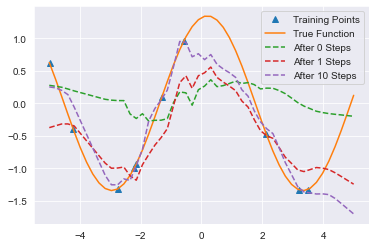

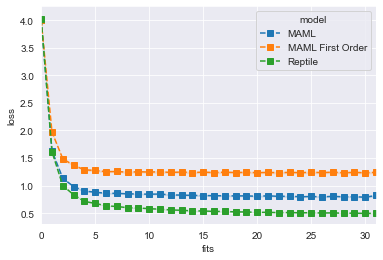

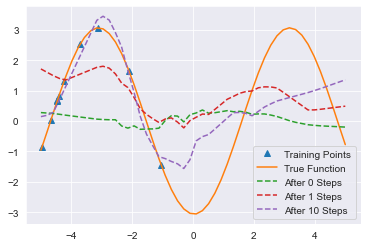

In [19]:
plot_sine_test(SINE_REPTILE[0], SINE_TEST[0], fits=[0, 1, 10], lr=0.01)
plt.show()

plot_sine_learning(
    [('MAML', SINE_MAML), ('MAML First Order', SINE_MAML_FIRST_ORDER), ('Reptile', SINE_REPTILE)],
    list(range(32)),
)
plt.show()

plot_sine_test(SINE_REPTILE[0], ONE_SIDED_EXAMPLE, fits=[0, 1, 10], lr=0.01)
plt.show()

It looks like Reptile does indeed achieve similar or even slightly better performance to MAML with a much simpler and slightly faster algorithm! Very exciting. And this applies to many more problems than just this toy example of sine waves! For more details, I really do recommend you read the paper. At this point, you should have enough background to understand them quite easily.